## Introduction

This notebook outlines how to build a Recommendation system using SageMaker's Factorization Machines (FM) and KNN. This is outcome of a 3 day workshop at AWS NYC Office(from Sept 18th-20th, 2019). 

There are following parts to this notebook:

1. Building a FM Model
2. Hyperparameter Tuning
3. Hyperparameter Tuning Analysis
3. Repackaging FM Model to fit a KNN Model
4. Building a KNN model
5. Running Batch Transform for predicting top "X" items
6. Deploying the model to an endpoint

This Notebook can be easily extended to create a production-ready Recommendation System with a couple of modifications. I have been able to customize it to prototype a production-ready version of User-Based Recommendations on a real dataset in these 3 days.

In [6]:
import json
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import json_deserializer
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
import pandas as pd
import boto3, io, os

In [43]:
random_state=101
sess = sagemaker.Session()
bucket = "bucket name"
base = 'movie-lens'
stage = "dev"
data_prefix = f"/{stage}/data/{base}"

role = sagemaker.get_execution_role()

# 1. Data Preparation

## Download movie rating data from movie lens

In [6]:

#download data
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip

--2019-09-22 19:05:14--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.2’

ml-100k.zip.2       100%[===================>]   4.70M  5.92MB/s    in 0.8s    

2019-09-22 19:05:15 (5.92 MB/s) - ‘ml-100k.zip.2’ saved [4924029/4924029]

Archive:  ml-100k.zip
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflat

## Shuffle Data

In [30]:
%cd ml-100k
!shuf ua.base -o ua.base.shuffled

/home/ec2-user/SageMaker/ml-100k


## Load Data

In [31]:
df = pd.read_csv('ua.base.shuffled', sep='\t', index_col=False, 
                 names=['user_id' , 'movie_id' , 'rating'])
df.head()

,user_id,movie_id,rating
0,454,203,2
1,42,48,5
2,345,405,4
3,407,484,4
4,938,255,1


# Feature Engineering

Instead of 5 categories, we are changing the problem to binary classification problem where ratings less than 4 are 0 and more than 4 are 1.

In [32]:
mask = (df.rating<=4)
df.loc[mask, "rating"]=0
df.loc[~mask, "rating"]=1

In [33]:
df.head(5)

,user_id,movie_id,rating
0,454,203,0
1,42,48,1
2,345,405,0
3,407,484,0
4,938,255,0


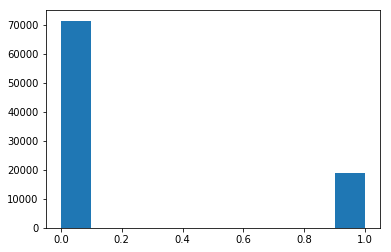

In [35]:
from matplotlib import pyplot

pyplot.hist(df.rating)
pyplot.show()

In [36]:
df.rating.value_counts()

0    71522
1    19048
Name: rating, dtype: int64

### Utility function for calculating Fuction execution time

In [37]:
import time
from functools import wraps

def timeit(f):
    @wraps(f)
    def wrapper(*args,**kwargs):
        start_time = time.time()
        result = f(*args,**kwargs)
        elapsed_time = time.time()-start_time
        print("Elapsed computation time: {:.3f} secs".format(elapsed_time))
        return (elapsed_time, result)
    return wrapper

### FM Input

Input to FM is a one-hot encoded sparse matrix. 

# Dealing with Outliers

## Removing users who have watched <5 movies and items which have <10 viewers

In [38]:
users = df['user_id'].value_counts()
titles = df['movie_id'].value_counts()

In [39]:
users = users[users >= 5]
titles = titles[titles >= 10]

reduced_df = df.merge(pd.DataFrame({'user_id': users.index})).merge(pd.DataFrame({'movie_id': titles.index}))

## Creating incremental index for users and items

In [40]:
user = {}
for index, value in enumerate(reduced_df.user_id.unique().tolist()):
    if value not in user:
        user[value] = index
        
item = {}
for index, value in enumerate(reduced_df.movie_id.unique().tolist()):
    if value not in item:
        item[value] = index

reduced_df['user'] = reduced_df['user_id'].map(user)
reduced_df['item'] = reduced_df['movie_id'].map(item)
reduced_df.head()

,user_id,movie_id,rating,user,item
0,454,203,0,0,0
1,42,203,0,1,0
2,407,203,0,2,0
3,72,203,0,3,0
4,405,203,0,4,0


In [41]:
reduced_df.describe()

,user_id,movie_id,rating,user,item
count,88478.000000,88478.000000,88478.000000,88478.000000,88478.000000
mean,461.698422,409.516467,0.213059,280.956091,378.159520
std,266.181032,309.536824,0.409471,233.823483,287.862816
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,256.000000,173.000000,0.000000,87.000000,140.000000
50%,445.000000,318.000000,0.000000,214.000000,308.000000
75%,682.000000,607.000000,0.000000,444.000000,562.000000
max,943.000000,1615.000000,1.000000,942.000000,1131.000000


## Train test Split

In [44]:
from sklearn.model_selection import train_test_split

X = reduced_df.drop(["rating"], axis=1)
y = reduced_df["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [45]:
num_users=X.user.nunique()
num_items=X.item.nunique()
feature_dim = num_users + num_items

In [46]:
X_train.head()

,user_id,movie_id,user,item
35085,183,380,166,230
67478,605,340,426,587
28286,933,238,201,186
28956,412,169,447,190
32321,360,302,191,210


In [47]:
X_test.head()

,user_id,movie_id,user,item
72162,798,940,288,663
52876,449,14,696,395
70538,339,770,149,639
16408,721,245,224,106
31162,806,195,473,203


In [48]:
X.shape

(88478, 4)

In [49]:
y_test.shape

(17696,)

In [50]:
feature_dim

2075

In [35]:
# @timeit
def to_csr_matrix(df, num_users, num_items):
    feature_dim = num_users + num_items
    data = np.concatenate([np.array([1] * df.shape[0]),
                           np.array([1] * df.shape[0]),
                          np.array([1] * df.shape[0])])
    row = np.concatenate([np.arange(df.shape[0])] * 3)
    col = np.concatenate([df['user'].values,
                          df['item'].values,
                          np.array([feature_dim-1] * df.shape[0])])
    return csr_matrix((data, (row, col)), 
                      shape=(df.shape[0], feature_dim), 
                      dtype=np.float32)

In [36]:
train_csr = to_csr_matrix(X_train, num_users, num_items)
val_csr = to_csr_matrix(X_val, num_users, num_items)
test_csr = to_csr_matrix(X_test, num_users, num_items)

In [37]:
feature_dim = num_users + num_items
feature_dim

2075

## Save Data to S3 in protobuf

In [41]:

def to_s3_protobuf(csr, label, bucket, prefix, channel='train', splits=10):
    indices = np.array_split(np.arange(csr.shape[0]), splits)
    for i in range(len(indices)):
        index = indices[i]
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(buf, csr[index, ], label[index])
        buf.seek(0)
        boto3.client('s3').upload_fileobj(buf, bucket, '{}/{}/data-{}'.format(prefix, channel, i))
to_s3_protobuf(train_csr, y_train.values.astype(np.float32), bucket, data_prefix)
to_s3_protobuf(val_csr, y_val.values.astype(np.float32), bucket, data_prefix, channel='validation', splits=1)
to_s3_protobuf(test_csr, y_test.values.astype(np.float32), bucket, data_prefix, channel='test', splits=1)

# Hyperparameter Tuning

In [42]:
hyperparameters=dict(
    predictor_type='binary_classifier',
    mini_batch_size=1000,
    num_factors=64,
    epochs=100,
    feature_dim=feature_dim,
)

In [43]:
base = "factorization-machine"
model_prefix = f"/{stage}/models/{base}"
fm = sagemaker.estimator.Estimator(
    sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'factorization-machines', 'latest'),
    role, 
    train_instance_count=4, 
    train_instance_type='ml.c5.2xlarge',
    output_path='s3://{}/{}/output'.format(bucket, model_prefix),
    base_job_name=base,
    sagemaker_session=sess,
    hyperparameters = hyperparameters
)


In [46]:
hyperparameter_ranges = {
                        'epochs': IntegerParameter(128,512),
                        'mini_batch_size': IntegerParameter(32, 128),
                        'bias_init_sigma': ContinuousParameter(1e-8,512),
                        'factors_init_sigma': ContinuousParameter(1e-8,512),
                        'linear_init_sigma': ContinuousParameter(1e-8,512)
                        }

Objective metric includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. In this particular case, our script emits loss value and we will use it as the objective metric, we also set the objective_type to be 'minimize', so that hyperparameter tuning seeks to minize the objective metric when searching for the best hyperparameter setting. By default, objective_type is set to 'maximize'.

In [48]:
objective_metric_name = 'test:binary_classification_accuracy'
objective_type = 'Maximize'

In [49]:
tuner = HyperparameterTuner(fm,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=9,
                            max_parallel_jobs=3,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

In [50]:

tuner.fit({'train': sagemaker.s3_input('s3://{}/{}/train/'.format(bucket, data_prefix), distribution='ShardedByS3Key'), 
        'validation': sagemaker.s3_input('s3://{}/{}/validation/'.format(bucket, data_prefix), distribution='FullyReplicated'),
        'test': sagemaker.s3_input('s3://{}/{}/test/'.format(bucket, data_prefix), distribution='FullyReplicated')})

# Hyperparameter Tuning job Analysis

Once a tuning job is completed, (or even while the job is still running) you can use this notebook to analyze the results to understand how each hyperparameter effects the quality of the model.

---

In [92]:
tuning_job_name = tuner.name

In [8]:
metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()
metrics.sort_values(['FinalObjectiveValue'], ascending=False)

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,bias_init_sigma,epochs,factors_init_sigma,linear_init_sigma,mini_batch_size
7,0.589568,206.0,2019-09-22 19:32:40+00:00,factorization-machin-190922-1926-002-a510e60d,Completed,2019-09-22 19:29:14+00:00,1.268422e+00,400.0,2.787108e-07,0.000237,103.0
0,0.586912,190.0,2019-09-22 19:52:16+00:00,factorization-machin-190922-1926-009-9e25fe14,Completed,2019-09-22 19:49:06+00:00,5.942705e-01,399.0,3.217348e-06,0.000073,113.0
2,0.582278,276.0,2019-09-22 19:46:07+00:00,factorization-machin-190922-1926-007-62c6f3c9,Completed,2019-09-22 19:41:31+00:00,2.306862e+00,450.0,1.022426e-06,0.000015,116.0
4,0.571316,328.0,2019-09-22 19:40:20+00:00,factorization-machin-190922-1926-005-a4aacaf8,Completed,2019-09-22 19:34:52+00:00,1.654394e+01,499.0,2.245651e-08,0.000017,93.0
6,0.568547,349.0,2019-09-22 19:35:12+00:00,factorization-machin-190922-1926-003-70297c41,Completed,2019-09-22 19:29:23+00:00,4.465280e-05,495.0,7.896902e-02,0.005694,70.0
5,0.568094,236.0,2019-09-22 19:37:52+00:00,factorization-machin-190922-1926-004-2d1de460,Completed,2019-09-22 19:33:56+00:00,2.070636e+02,485.0,1.784644e-05,2.942693,114.0
3,0.566230,405.0,2019-09-22 19:48:00+00:00,factorization-machin-190922-1926-006-7476b9af,Completed,2019-09-22 19:41:15+00:00,4.652549e+01,452.0,1.685160e-06,0.000029,49.0
8,0.557188,87.0,2019-09-22 19:31:06+00:00,factorization-machin-190922-1926-001-8f9c177d,Completed,2019-09-22 19:29:39+00:00,1.445172e-08,179.0,1.691520e+00,8.773734,128.0
1,0.524864,278.0,2019-09-22 19:47:17+00:00,factorization-machin-190922-1926-008-b3e5bda4,Stopped,2019-09-22 19:42:39+00:00,5.043952e-02,278.0,3.441626e+01,0.146788,36.0


## Hyperparameter tuning job progress

In [9]:
tuning_job_result = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
best_tuning_job = tuning_job_result.get('BestTrainingJob',None)

In [10]:
status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

8 training jobs have completed


In [11]:
from pprint import pprint
if best_tuning_job:
    print("Best model found so far:")
    pprint(best_tuning_job)
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2019, 9, 22, 19, 27, 5, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'test:binary_classification_accuracy',
                                                 'Value': 0.5895682573318481},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2019, 9, 22, 19, 32, 40, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:291053455966:training-job/factorization-machin-190922-1926-002-a510e60d',
 'TrainingJobName': 'factorization-machin-190922-1926-002-a510e60d',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2019, 9, 22, 19, 29, 14, tzinfo=tzlocal()),
 'TunedHyperParameters': {'bias_init_sigma': '1.2684224607134875',
                          'epochs': '400',
                          'factors_init_sigma': '2.7871077413940573e-07',
                          'linear_init_sigma': '0.0002369639261709435',
                          'mini_bat

## Hyperparameter Job results
We can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [16]:
tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    result_df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(result_df) > 0:
        result_df = result_df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(result_df))
        print({"lowest":min(result_df['FinalObjectiveValue']),"highest": max(result_df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # To avoid truncating TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
result_df

Number of training jobs with valid objective: 9
{'lowest': 0.5248643755912781, 'highest': 0.5895682573318481}


,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,bias_init_sigma,epochs,factors_init_sigma,linear_init_sigma,mini_batch_size
7,0.589568,206.0,2019-09-22 19:32:40+00:00,factorization-machin-190922-1926-002-a510e60d,Completed,2019-09-22 19:29:14+00:00,1.268422e+00,400.0,2.787108e-07,0.000237,103.0
0,0.586912,190.0,2019-09-22 19:52:16+00:00,factorization-machin-190922-1926-009-9e25fe14,Completed,2019-09-22 19:49:06+00:00,5.942705e-01,399.0,3.217348e-06,0.000073,113.0
2,0.582278,276.0,2019-09-22 19:46:07+00:00,factorization-machin-190922-1926-007-62c6f3c9,Completed,2019-09-22 19:41:31+00:00,2.306862e+00,450.0,1.022426e-06,0.000015,116.0
4,0.571316,328.0,2019-09-22 19:40:20+00:00,factorization-machin-190922-1926-005-a4aacaf8,Completed,2019-09-22 19:34:52+00:00,1.654394e+01,499.0,2.245651e-08,0.000017,93.0
6,0.568547,349.0,2019-09-22 19:35:12+00:00,factorization-machin-190922-1926-003-70297c41,Completed,2019-09-22 19:29:23+00:00,4.465280e-05,495.0,7.896902e-02,0.005694,70.0
5,0.568094,236.0,2019-09-22 19:37:52+00:00,factorization-machin-190922-1926-004-2d1de460,Completed,2019-09-22 19:33:56+00:00,2.070636e+02,485.0,1.784644e-05,2.942693,114.0
3,0.566230,405.0,2019-09-22 19:48:00+00:00,factorization-machin-190922-1926-006-7476b9af,Completed,2019-09-22 19:41:15+00:00,4.652549e+01,452.0,1.685160e-06,0.000029,49.0
8,0.557188,87.0,2019-09-22 19:31:06+00:00,factorization-machin-190922-1926-001-8f9c177d,Completed,2019-09-22 19:29:39+00:00,1.445172e-08,179.0,1.691520e+00,8.773734,128.0
1,0.524864,278.0,2019-09-22 19:47:17+00:00,factorization-machin-190922-1926-008-b3e5bda4,Stopped,2019-09-22 19:42:39+00:00,5.043952e-02,278.0,3.441626e+01,0.146788,36.0


## TuningJob results vs time
Next we will show how the objective metric changes over time, as the tuning job progresses.  For Bayesian strategy, a general trend towards better results is observed, but this progress will not be steady as the algorithm needs to balance _exploration_ of new areas of parameter space against _exploitation_ of known good areas.  This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [17]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

Loading BokehJS ...

In [18]:
class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

In [21]:


hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=result_df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

## Correlation between objective metric and individual hyperparameters 
The correlation between objective metric and individual hyperparameters will help decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For example, if there is a positive trend between objective metric and a numerical hyperparameter, we probably want to set a higher tuning range for that hyperparameter in the next tuning job.

The following cell draws a graph for each hyperparameter to show its correlation with objective metric.

In [23]:
ranges = tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Checking if all options are actually numbers is important.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=result_df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

# Extracting the Factorization Machine Model artifact

In [26]:
import os
import mxnet as mx
import numpy as np
model_file_name = "model.tar.gz"
model_full_path = <full-model-path>+model_file_name

In [27]:
#Download FM model 
!aws s3 cp {model_full_path} ./
#Extract model file for loading to MXNet
!tar xzvf {model_file_name}
!unzip -o model_algo-1
!mv symbol.json model-symbol.json
!mv params model-0000.params

download: s3://ml.epix.com//dev/models/factorization-machine/output/factorization-machin-190922-1926-002-a510e60d/output/model.tar.gz to ./model.tar.gz
model_algo-1
Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


In [28]:
#Extract model data
m = mx.module.Module.load('./model', 0, False, label_names=['out_label'])
V = m._arg_params['v'].asnumpy()
w = m._arg_params['w1_weight'].asnumpy()
b = m._arg_params['w0_weight'].asnumpy()

In [51]:
knn_item_matrix = np.concatenate((V[num_users:], w[num_users:]), axis=1)
knn_train_label = np.arange(num_items)

#user latent matrix - concat (V[u], 1) 
ones = np.ones(num_users).reshape((num_users, 1))
knn_user_matrix = np.concatenate((V[:num_users], ones), axis=1)

In [86]:
if bucket.strip() == '':
    raise RuntimeError("bucket name is empty.")

train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test')

In [128]:
def write_dataset_to_protobuf(X, bucket, prefix, d_type, Y=None, channel="train"):
    buf = io.BytesIO()
    if d_type == "sparse":
        smac.write_spmatrix_to_sparse_tensor(buf, X, labels=Y)
    else:
        smac.write_numpy_to_dense_tensor(buf, X, labels=Y)
        
    buf.seek(0)
    obj = '{}/{}'.format(prefix, channel)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)

## Building KNN

In [129]:
from sagemaker.amazon.amazon_estimator import get_image_uri
instance_type='ml.m5.large'
print('KNN train features shape = ', knn_item_matrix.shape)

KNN train features shape =  (1132, 65)


In [165]:
base = "movie-lens"
knn_algo = "knn"
knn_data_prefix = f"{stage}/data/{base}/{knn_algo}"
model_prefix = f"{stage}/models/{base}/{knn_algo}"
inference_prefix = f"{stage}/inferences/{base}/{knn_algo}"
knn_output_path  = 's3://{}/{}'.format(bucket, inference_prefix)
knn_batch_input_prefix = f"{inference_prefix}/batch/input"
knn_batch_output_prefix = f"{inference_prefix}/batch/output"
knn_batch_output_path = 's3://{}/{}'.format(bucket, knn_batch_output_prefix)

In [137]:
knn_train_data_path = write_dataset_to_protobuf(knn_item_matrix, bucket, knn_data_prefix, "dense", knn_train_label, channel="train")
print('Uploaded KNN train data: {}'.format(knn_train_data_path))

Uploaded KNN train data: s3://ml.epix.com/dev/data/movie-lens/knn/train


In [166]:
knn_output_path

's3://ml.epix.com/dev/inferences/movie-lens/knn'

In [167]:
knn_batch_output_path

's3://ml.epix.com/dev/inferences/movie-lens/knn/batch/output'

In [156]:
knn_batch_output_prefix

'dev/inferences/movie-lens/knn/batch/output'

In [160]:
nb_recommendations = 20
# set up the estimator
knn = sagemaker.estimator.Estimator(get_image_uri(boto3.Session().region_name, "knn"),
    sagemaker.get_execution_role(),
    train_instance_count=1,
    train_instance_type=instance_type,
    output_path=knn_output_path,
    sagemaker_session=sagemaker.Session())

knn.set_hyperparameters(feature_dim=knn_item_matrix.shape[1], k=nb_recommendations, index_metric="INNER_PRODUCT", predictor_type='classifier', sample_size=200000)
fit_input = {'train': knn_train_data_path}
knn.fit(fit_input)

2019-09-23 04:00:57 Starting - Starting the training job...
2019-09-23 04:00:59 Starting - Launching requested ML instances......
2019-09-23 04:02:04 Starting - Preparing the instances for training...
2019-09-23 04:02:50 Downloading - Downloading input data...
2019-09-23 04:03:12 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[09/23/2019 04:03:35 INFO 140352921110336] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000'}
[09/23/2019 04:03:35 INFO 140352921110336] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'sample_size': u'200000', u'feature_dim': u'


2019-09-23 04:03:51 Uploading - Uploading generated training model
2019-09-23 04:03:51 Completed - Training job completed
Training seconds: 61
Billable seconds: 61


# Save the KNN model to do Batch Inference

In [161]:
sm = boto3.client(service_name='sagemaker')
primary_container = {
    'Image': knn.image_name,
    'ModelDataUrl': knn.model_data,
}
knn_model_name =  knn.latest_training_job.job_name
print("created model: ", knn_model_name)

knn_model = sm.create_model(
        ModelName = knn.latest_training_job.job_name,
        ExecutionRoleArn = knn.role,
        PrimaryContainer = primary_container)
print("saved the model")

created model:  knn-2019-09-23-04-00-57-611
saved the model


# Batch Transform

In [168]:
#upload inference data to S3
knn_batch_data_path = write_dataset_to_protobuf(knn_user_matrix, bucket, knn_batch_input_prefix,"dense",  channel="train")
print("Batch inference data path: ",knn_batch_data_path)

# Initialize the transformer object
transformer =sagemaker.transformer.Transformer(
    base_transform_job_name="knn",
    model_name=knn_model_name,
    instance_count=1,
    instance_type=instance_type,
    output_path=knn_batch_output_path,
    strategy="MultiRecord",
    accept="application/jsonlines; verbose=true"
)

# Start a transform job:
transformer.transform(knn_batch_data_path, split_type="RecordIO",content_type='application/x-recordio-protobuf')
transformer.wait()


Batch inference data path:  s3://ml.epix.com/dev/inferences/movie-lens/knn/batch/input/train
......................Docker entrypoint called with argument(s): serve
[09/23/2019 04:22:04 INFO 140415412217664] loaded entry point class algorithm.serve.server_config:config_api
[09/23/2019 04:22:04 INFO 140415412217664] loading entry points
[09/23/2019 04:22:04 INFO 140415412217664] loaded request iterator text/csv
[09/23/2019 04:22:04 INFO 140415412217664] loaded request iterator application/x-recordio-protobuf
[09/23/2019 04:22:04 INFO 140415412217664] loaded request iterator application/json
[09/23/2019 04:22:04 INFO 140415412217664] loaded request iterator application/jsonlines
[09/23/2019 04:22:04 INFO 140415412217664] loaded response encoder application/x-recordio-protobuf
[09/23/2019 04:22:04 INFO 140415412217664] loaded response encoder application/json
[09/23/2019 04:22:04 INFO 140415412217664] loaded response encoder application/jsonlines
[09/23/2019 04:22:04 INFO 140415412217664] 

# Create Inference Endpoint for real time predictions

In [ ]:
knn_predictor = knn.deploy(instance_type='ml.m4.xlarge', initial_instance_count=1)

# Testing Inferences using Batch

In [192]:
#Download predictions 
results_file_name = "train.out"
s3_client = boto3.client('s3')
print('bucket: {}, object: {}, file: {}'.format(bucket, knn_batch_output_prefix, results_file_name))
s3_client.download_file(bucket, f"{knn_batch_output_prefix}/{results_file_name}", results_file_name)
with open(results_file_name) as f:
    results = f.readlines()  

bucket: ml.epix.com, object: dev/inferences/movie-lens/knn/batch/output, file: train.out


## Title User has already Watched

In [227]:
item_df = pd.read_csv('u.item', sep='|', encoding = "ISO-8859-1", names=[ "movie_id", "title", "release date","video release date",
              "IMDb URL", "unknown", "Action","Adventure","Animation","Children's","Comedy", "Crime", "Documentary", "Drama", "Fantasy"
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance" ,"Sci-Fi",
              "Thriller","War", "Western"], index_col=False)
item_df.head()

,movie_id,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Drama,FantasyFilm-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [231]:
merged_df = reduced_df.merge(item_df[["movie_id","title"]], on ="movie_id")

In [236]:
user_idx=0
no_of_items = 15
merged_df[merged_df.user==user_idx][["user","movie_id", "title", "rating"]].head(20)

,user,movie_id,title,rating
0,0,203,Unforgiven (1992),0
170,0,735,Philadelphia (1993),0
301,0,520,"Great Escape, The (1963)",0
417,0,140,Homeward Bound: The Incredible Journey (1993),0
472,0,519,"Treasure of the Sierra Madre, The (1948)",0
547,0,272,Good Will Hunting (1997),1
707,0,1126,"Old Man and the Sea, The (1958)",0
738,0,1107,Beyond Rangoon (1995),0
755,0,528,"Killing Fields, The (1984)",0
867,0,480,North by Northwest (1959),0


In [229]:
def get_user_recommendations(user_idx, no_of_items):
    count = 0
    count = count + 1
    predictions=json.loads(results[user_idx])
    pred_df = pd.DataFrame(predictions)
    final_pred_df=item_df.merge(pred_df, left_on="movie_id", right_on="labels")
    rec_df = final_pred_df.sort_values(by=["distances"])[["title", "distances"]].head(no_of_items)
    return rec_df
get_user_recommendations(user_idx, no_of_items)

,title,distances
8,"Shawshank Redemption, The (1994)",5.575968
7,"Madness of King George, The (1994)",6.774959
12,"Lawnmower Man, The (1992)",7.196866
5,Mad Love (1995),8.091030
4,Free Willy 2: The Adventure Home (1995),8.509869
0,Get Shorty (1995),9.445670
15,12 Angry Men (1957),9.581314
6,"To Wong Foo, Thanks for Everything! Julie Newmar (1995)",10.858761
16,GoodFellas (1990),11.066724
9,Carlito's Way (1993),12.295348


# Method

## 1. Which model did you select, and why?

As we have build a Recommender System, we have picked an algorithm which can efficiently deal with Sparse data sets, factorization machine. Factorization Machine is highly scalable and designed to efficiently translate high dimension data to a lower dimension. We followed the blog post to find `user-item` affinity score and then built TopN recommender by applying `K-Nearest Neighbors`. It would be interesting to create another recommendation models using other popular algorithms like: 
- `Restricted Boltzman Machine`
- `Object2Vec`
- `Auto-encoders`
- `SVD++` 

and perform `AB test`.


## 2. How are you evaluating your model?

I have framed the problem statement as a Classification problem and therefore evaluated model based on `accuracy`. However, evaluating a Recommender System based on only accuracy would not be wise as our end objective is to optimize based on the Top N recommendations(metrics like `Average reciprocal Hit Rate` or `Discounted Cummulative Gain`).

## 3. Is your model overfitting, and what are you doing to counteract that?

The model was overfitting earlier when number of latent factors(`hyperparameter=num_factors`) was high. Reducing the number improved the model accuracy.

## 3. What are the limitations of your model, and what are its strong points?

Limitations:
- Model interpretability is an issue when dealing with `Factorization Machine`.
- As `K-Nearest Neighbors` is a memory based approach it may lead to scalibility issues with large datasets. I have been able to use it easily with a dataset having several million datapoints but definitely it would be a problem when the scale of the problem increases further.

Strong points:
- `Factorization Machine` is popular and open source algorithm so it is easy to come up with custom receipe using it
- `K-Nearest Negihbors` is highly intuitive


## What are the guardrails on the your model performance metrics? What is the minimum and maximum accuracy you expect to achieve?



As we framed our problem as classification problem(whether user will `Like` an item or `Dislike`), we used `Accuracy` as our primary performance metric. 

- Best accuracy: 0.8268082141876221
- Minimum accuracy: 0.25149303674697876



# Additional References
---

## Factorization Machine

- Factorization machines combine linear prediction with a factorized representation of pairwise feature interaction
- The global bias and linear terms are the same as in a linear model. The pairwise feature interactions are modeled in the third term as the inner product of the corresponding factors learned for each feature. Learned factors can also be considered as embedding vectors for each feature.

$$\hat{r} = w_0 + \sum_{i} {w_i x_i} + \sum_{i} {\sum_{j > i} {\langle v_i, v_j \rangle x_i x_j}}$$

- This is the original research paper on __factorization machines__, [this paper](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)

## Hyperparameter Optimization

I have referred following book and research papers for choosing the optimal hyperparameter:
- http://www.deeplearningbook.org/contents/optimization.html
- http://www.deeplearningbook.org/contents/numerical.html
- https://arxiv.org/abs/1609.04836 